In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
import math
import os
import PIL
import PIL.Image
import tensorflow_hub as hub

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [10]:
print(tf.__version__)

2.3.0


In [11]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [12]:
# To run on GPU using PlaidML

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [13]:
tf.test.gpu_device_name()

''

In [14]:
# Setting up the folders

data_dir = '/Users/abhi/Documents/Abhi/Datasets/Skin_Cancer_Data_2class'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir  = data_dir + '/test'

train_nevus_dir = os.path.join(train_dir, 'nevus')       # directory with our training nevus pictures
train_melanoma_dir = os.path.join(train_dir, 'melanoma')    # directory with our training melanoma pictures
#train_seborrheic_keratosis_dir = os.path.join(train_dir, 'seborrheic_keratosis')    # directory with our training seborrheic_keratosis pictures

valid_nevus_dir = os.path.join(valid_dir, 'nevus')       # directory with our validate nevus pictures
valid_melanoma_dir = os.path.join(valid_dir, 'melanoma')    # directory with our validate melanoma pictures
#valid_seborrheic_keratosis_dir = os.path.join(valid_dir, 'seborrheic_keratosis')    # directory with our validate seborrheic_keratosis pictures

test_nevus_dir = os.path.join(test_dir, 'nevus')       # directory with our test nevus pictures
test_melanoma_dir = os.path.join(test_dir, 'melanoma')    # directory with our test melanoma pictures
#test_seborrheic_keratosis_dir = os.path.join(test_dir, 'seborrheic_keratosis')    # directory with our test seborrheic_keratosis pictures

print(train_dir)
print(train_melanoma_dir)

/Users/abhi/Documents/Abhi/Datasets/Skin_Cancer_Data_2class/train
/Users/abhi/Documents/Abhi/Datasets/Skin_Cancer_Data_2class/train/melanoma


In [15]:
# Setting global parameters

batch_size = 20
image_size = 224

In [16]:
# Loading training image datasets 

image_gen = ImageDataGenerator(rescale=1./255) #, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(image_size,image_size)
                                              ,class_mode='sparse'
                                              )

Found 1746 images belonging to 2 classes.


In [17]:
# Function to plot images

def plotImages(images_arr):
    fig, axes = plt.subplots(figsize=(6, 4))
    
    #images_arr = images_arr.reshape((150, 150, 3))
    axes.imshow(images_arr)
    plt.tight_layout()
    plt.show()

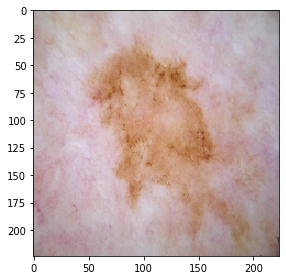

In [18]:
# Plotting a sample training image

plotImages(train_data_gen[0][0][0])

In [19]:
# Image augmentation

image_gen_train = ImageDataGenerator(
                                      rescale=1./255,
                                      rotation_range=45,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(image_size,image_size)
                                                     ,class_mode='sparse'
                                                     )

Found 1746 images belonging to 2 classes.


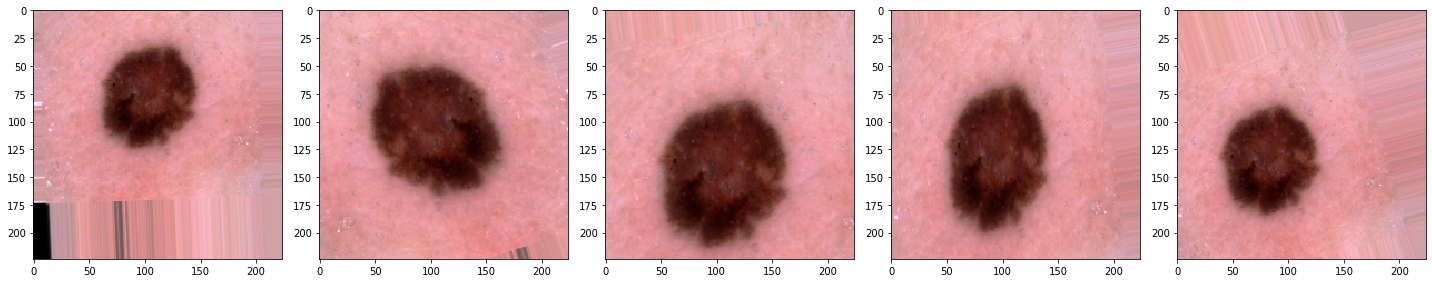

In [20]:
# Plotting a sample augmented training image

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

# Plotting 1st image 5 times
fig, axes = plt.subplots(1, 5, figsize=(20,20))
    
axes = axes.flatten()
for img, ax in zip(augmented_images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [21]:
for image_batch, labels_batch in train_data_gen:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch)
    break

(20, 224, 224, 3)
(20,)
[1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.]


In [22]:
# Calculating the number of images in the training datasets and its subfolders

train_nevus_size = len(os.listdir(train_nevus_dir))
train_melanoma_size = len(os.listdir(train_melanoma_dir))
#train_keratosis_size = len(os.listdir(train_seborrheic_keratosis_dir))

train_size = train_nevus_size + train_melanoma_size #+ train_keratosis_size

print('Training set (nevus): ', train_nevus_size)
print('Training set (melanoma): ', train_melanoma_size)
#print('Training set (seborrheic-keratosis): ', train_keratosis_size)
print('Total training dataset images: ', train_size)

Training set (nevus):  1372
Training set (melanoma):  374
Total training dataset images:  1746


In [23]:
# Data prep for validation folder with normalization

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=valid_dir,
                                                 target_size=(image_size, image_size),
                                                 class_mode='sparse'
                                                )

Found 108 images belonging to 2 classes.


In [24]:
# Calculating the number of images in the validate datasets and its subfolders

valid_nevus_size = len(os.listdir(valid_nevus_dir))
valid_melanoma_size = len(os.listdir(valid_melanoma_dir))
#valid_keratosis_size = len(os.listdir(valid_seborrheic_keratosis_dir))

valid_size = valid_nevus_size + valid_melanoma_size #+ valid_keratosis_size

print('validation set (nevus): ', valid_nevus_size)
print('validation set (melanoma): ', valid_melanoma_size)
#print('validation set (seborrheic-keratosis): ', valid_keratosis_size)
print('Total validation dataset images: ', valid_size)

validation set (nevus):  78
validation set (melanoma):  30
Total validation dataset images:  108


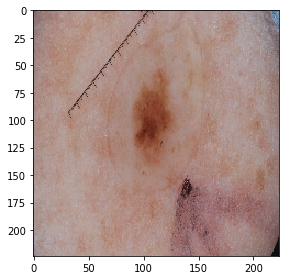

In [25]:
# Plotting a sample validate image

plotImages(val_data_gen[0][0][0])

In [26]:
# Data prep for test folder with normalization

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                 directory=test_dir,
                                                 target_size=(image_size, image_size),
                                                 class_mode='sparse'
                                                  )

Found 510 images belonging to 2 classes.


In [27]:
# Calculating the number of images in the test datasets and its subfolders

test_nevus_size = len(os.listdir(test_nevus_dir))
test_melanoma_size = len(os.listdir(test_melanoma_dir))
#test_keratosis_size = len(os.listdir(test_seborrheic_keratosis_dir))

test_size = test_nevus_size + test_melanoma_size #+ test_keratosis_size

print('testing set (nevus): ', test_nevus_size)
print('testing set (melanoma): ', test_melanoma_size)
#print('testing set (seborrheic-keratosis): ', test_keratosis_size)
print('Total testing dataset images: ', test_size)

testing set (nevus):  393
testing set (melanoma):  117
Total testing dataset images:  510


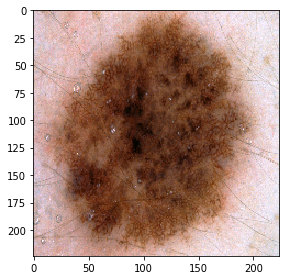

In [28]:
# Plotting a sample test image

plotImages(test_data_gen[0][0][0])

In [29]:
# Building the CNN model 

Transfer_model_URL = "https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/4"

IMAGE_RES = 224

feature_extractor = hub.KerasLayer(Transfer_model_URL,input_shape=(IMAGE_RES, IMAGE_RES,3))
feature_extractor.trainable = False 

In [31]:
# Setting up the layers 

model = tf.keras.Sequential([feature_extractor, layers.Dense(3, activation=tf.nn.softmax)])

In [32]:
# Compiling the model

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
              optimizer=opt, #'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             ) 

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              58295232  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 58,301,379
Trainable params: 6,147
Non-trainable params: 58,295,232
_________________________________________________________________


In [34]:
# Training the model

epochs= 10 #100

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit_generator(
                                train_data_gen,
                                steps_per_epoch=int(np.ceil(train_size / float(batch_size))),
                                epochs=epochs,
                                validation_data=val_data_gen,
                                validation_steps=int(np.ceil(valid_size / float(batch_size))),
                                callbacks=[early_stop]
                            )

Epoch 1/10
88/88 [==============================] - 386s 4s/step - loss: 0.8493 - accuracy: 0.7033 - val_loss: 0.8269 - val_accuracy: 0.7222
Epoch 2/10
88/88 [==============================] - 391s 4s/step - loss: 0.7677 - accuracy: 0.7858 - val_loss: 0.8259 - val_accuracy: 0.7222
Epoch 3/10
88/88 [==============================] - 357s 4s/step - loss: 0.7670 - accuracy: 0.7858 - val_loss: 0.8260 - val_accuracy: 0.7222
Epoch 4/10
88/88 [==============================] - 335s 4s/step - loss: 0.7660 - accuracy: 0.7858 - val_loss: 0.8255 - val_accuracy: 0.7222
Epoch 5/10
88/88 [==============================] - 336s 4s/step - loss: 0.7660 - accuracy: 0.7858 - val_loss: 0.8250 - val_accuracy: 0.7222
Epoch 6/10
88/88 [==============================] - 348s 4s/step - loss: 0.7657 - accuracy: 0.7858 - val_loss: 0.8241 - val_accuracy: 0.7222
Epoch 7/10
88/88 [==============================] - 387s 4s/step - loss: 0.7654 - accuracy: 0.7858 - val_loss: 0.8222 - val_accuracy: 0.7222
Epoch 8/10
88

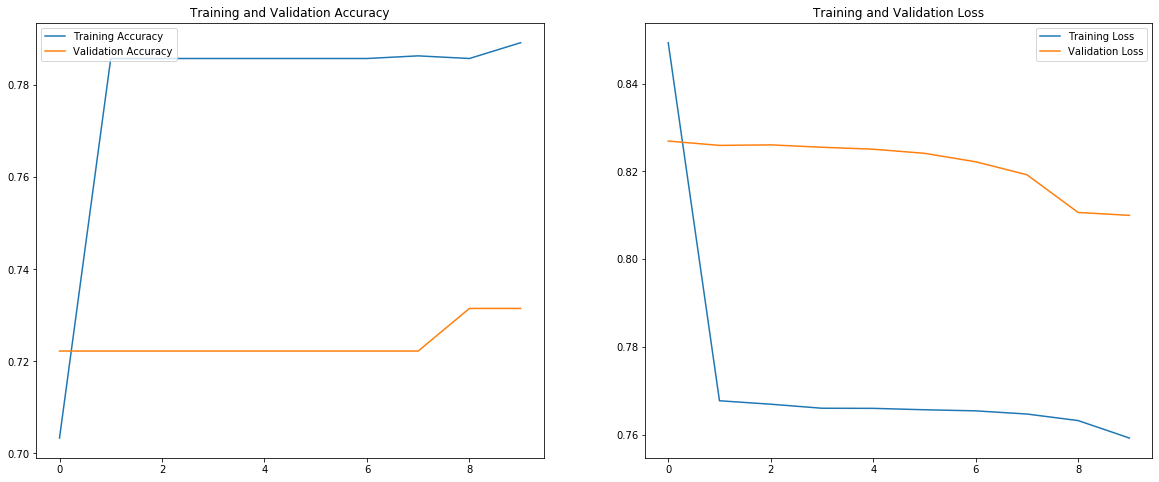

In [35]:
# Evaluating the model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
model.save_weights('skin_cancer_model_transferLearning_2class.h5')

In [ ]:
loaders_transfer = dataloaders.copy()

In [ ]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet152(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = True

model_transfer.fc = nn.Linear(2048,3)
fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True

use_cuda = torch.cuda.is_available()   

print(model_transfer)
if use_cuda:
    model_transfer = model_transfer.cuda()

In [ ]:
model_transfer.load_state_dict(torch.load('final.pth'))

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.0000001)


In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx,(data,target) in enumerate(dataloaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output=model(data)
            loss=criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx%50==0:
                 print('Epoch: {} \tTraining Loss: {:.6f} '.format(epoch,train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data,target) in enumerate(dataloaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output=model(data)
            loss=criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min=valid_loss
            print("Saving your model ...............................")
        
        
    return model

In [ ]:
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

In [ ]:
torch.save(model_transfer.state_dict(), 'final.pth')

In [ ]:
from PIL import Image
from torch.autograd import Variable

class_names = [item[:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def skin_detector(img_path):
    image_transform=transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
    image = image_transform(Image.open(img_path))
    image = image.unsqueeze(0)
    prob_class = False
    
    if use_cuda:
        prob_class = model_transfer.forward(Variable(image.cuda())).cpu()
    else:
        prob_class = model_transfer.forward(Variable(image))
    
    return class_names[prob_class.data.numpy().argmax()]

In [ ]:
from PIL import Image
#from torch.autograd import Variable

def predict_cancer(img_path):
    skin = skin_detector(img_path)
    img = plt.imread(img_path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    if (skin):
        print(skin_detector(img_path))

In [ ]:
predict_cancer(test_dir + '/nevus/ISIC_0013226.jpg')

In [ ]:
predict_cancer(test_dir + '/melanoma/ISIC_0013833.jpg')

In [ ]:
predict_cancer(test_dir + '/seborrheic_keratosis/ISIC_0014500.jpg')

In [ ]:
predict_cancer(test_dir + '/seborrheic_keratosis/ISIC_0014647.jpg')

In [ ]:
predict_cancer(test_dir + '/seborrheic_keratosis/ISIC_0012248.jpg')

In [ ]:
predict_cancer(test_dir + '/nevus/ISIC_0013399.jpg')